In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.misc import derivative
from matplotlib import rc

import dm_density_profiles as dmd
import cgs as cgs

import df as df

import time

using cgs py


In [2]:
NFW = dmd.general_dm_profile('LT_NFW')
NFW.set_params(profile_shape_params=[1.0,3.0,1.0])
NFW.set_params(M_vir = 3.1E8 * cgs.Msun, r_vir = 1370.0 * cgs.pc)
NFW.set_params(r_decay = 0.1*NFW.r_vir, r_s = 795.0 * cgs.pc )

In [3]:
NFW_DF = df.DF(NFW)

#N_DM = 1.0E4
#M_DM = NFW.M_vir / N_DM


In [4]:
# find the range of the potential
r = np.linspace(0.0,1000.0,100.0)*cgs.kpc

rel_pot = NFW_DF.relative_potential(r)

# and pick a range of velocities
v = np.linspace(0.0,500.0 * cgs.km,100.0)
v_sqr = v*v

evals_low = rel_pot - np.min(0.5*v_sqr)
evals_high = rel_pot - np.max(0.5*v_sqr)

print np.min(evals_low), np.max(evals_low)
print np.min(evals_high), np.max(evals_high)

print np.min(rel_pot), np.max(rel_pot)

19644006142.2 3.24108253432e+13
-1.24998035599e+15 -1.21758917466e+15
19644006142.2 3.24108253432e+13


In [5]:
df_filename = 'LT_NFW_500.dat'

load_df = False

In [6]:
if load_df:

    f = NFW_DF.load_df(df_filename)
    
else:
    start = time.time()

    f = NFW_DF.compute(500, filename = df_filename)

    end = time.time()
    print "run time ", (end-start)/60.0, end-start
    
    # write to file
    #outf = open(df_filename,'w')
    #for i in np.arange(np.size(NFW_DF.f)):
    #    outf.write("%.8E %.8E\n"%(NFW_DF.E[i],NFW_DF.f[i]))
    #outf.close()

    
f_analytical = df.hernquist_df(NFW_DF.E, NFW_DF.dprof.M_sys, NFW_DF.dprof.r_s)


000 Computing value for E = 1.434E+12  - f = 6.797E-116
001 Computing value for E = 1.443E+12  - f = 1.433E-114
002 Computing value for E = 1.452E+12  - f = 2.948E-114
003 Computing value for E = 1.461E+12  - f = 5.426E-114
004 Computing value for E = 1.470E+12  - f = 9.600E-114
005 Computing value for E = 1.479E+12  - f = 1.667E-113
006 Computing value for E = 1.489E+12  - f = 2.864E-113
007 Computing value for E = 1.498E+12  - f = 4.886E-113
008 Computing value for E = 1.507E+12  - f = 8.290E-113
009 Computing value for E = 1.517E+12  - f = 1.400E-112
010 Computing value for E = 1.526E+12  - f = 2.355E-112
011 Computing value for E = 1.536E+12  - f = 3.947E-112
012 Computing value for E = 1.546E+12  - f = 6.589E-112
013 Computing value for E = 1.555E+12  - f = 1.096E-111
014 Computing value for E = 1.565E+12  - f = 1.817E-111
015 Computing value for E = 1.575E+12  - f = 3.000E-111
016 Computing value for E = 1.585E+12  - f = 4.938E-111
017 Computing value for E = 1.595E+12  - f = 8.0

/home/emerick/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)
df.py:290: RuntimeWarning: invalid value encountered in arcsin
  F = F * ( (1.0 - 2.0*E)*(8.0*E*E - 8.0*E - 3.0) + (3.0 * np.arcsin(np.sqrt(E)))/(np.sqrt(E*(1.0-E))))


 - f = 2.108E-79
run time  200.131861965 12007.9117179


df.py:290: RuntimeWarning: invalid value encountered in sqrt
  F = F * ( (1.0 - 2.0*E)*(8.0*E*E - 8.0*E - 3.0) + (3.0 * np.arcsin(np.sqrt(E)))/(np.sqrt(E*(1.0-E))))


In [7]:
print NFW_DF.f

[  6.79693415e-116   1.43252048e-114   2.94833939e-114   5.42634456e-114
   9.60018715e-114   1.66698608e-113   2.86392519e-113   4.88557838e-113
   8.28957441e-113   1.40016520e-112   2.35531364e-112   3.94678883e-112
   6.58905078e-112   1.09602435e-111   1.81659568e-111   3.00021805e-111
   4.93760296e-111   8.09764518e-111   1.32339687e-110   2.15535644e-110
   3.49827936e-110   5.65854608e-110   9.12176179e-110   1.46549583e-109
   2.34655633e-109   3.74478019e-109   5.95633512e-109   9.44273556e-109
   1.49207580e-108   2.34999394e-108   3.68921367e-108   5.77298533e-108
   9.00482072e-108   1.40012233e-107   2.17010875e-107   3.35297162e-107
   5.16439399e-107   7.92972607e-107   1.21382024e-106   1.85232150e-106
   2.81807032e-106   4.27434128e-106   6.46362573e-106   9.74498089e-106
   1.46484391e-105   2.19540794e-105   3.28065421e-105   4.88804093e-105
   7.26183043e-105   1.07572679e-104   1.58894954e-104   2.34033588e-104
   3.43727062e-104   5.03412823e-104   7.35220033e-

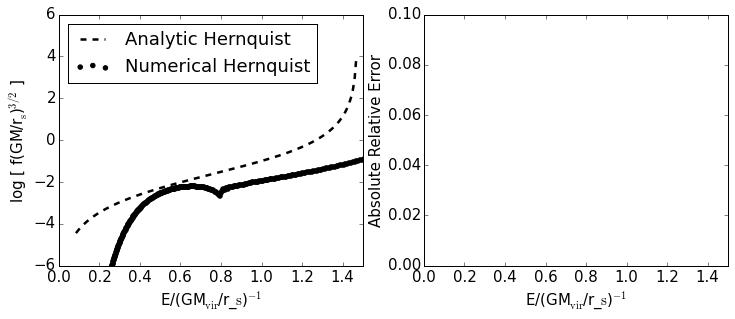

In [8]:
E_const = ((cgs.G * NFW_DF.dprof.M_vir) / NFW_DF.dprof.r_s)**(-1.0)
f_const = (cgs.G  * NFW_DF.dprof.M_vir * NFW_DF.dprof.r_s)**(3.0/2.0)

error = (NFW_DF.f - f_analytical)/f_analytical

error = np.abs(error)

fsize = 15
#rc('text', usetex=True)
rc('font', size=fsize)#, ftype=42)
line_width = 2.5

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,4.5)
#ax1 = plt.subplot(211)

ax[0].scatter(NFW_DF.E*E_const, np.log10(NFW_DF.f * f_const), label = "Numerical Hernquist",color='black')

#ax[0].plot(NFW_DF.E*E_const, np.log10(NFW_DF.f * f_const), lw=line_width, label = "Numerical Hernquist",color='black',ls='-')
ax[0].plot(NFW_DF.E*E_const, np.log10(f_analytical * f_const), lw=line_width, label="Analytic Hernquist", color='black',ls='--')
ax[0].set_ylabel(r'log [ f(GM/r$_{\rm{s}}$)$^{3/2}$ ]')
ax[0].set_ylim(-6,6)
ax[0].legend(loc='best')
#ax2 = plt.subplot(221)

ax[1].plot(NFW_DF.E * E_const, error, lw = line_width, color='black')
ax[1].set_ylabel(r'Absolute Relative Error')
for a in ax:
    a.set_xlim(0.0,1.5)
    a.set_xlabel(r'E/(GM$_{\rm{vir}}$/r_${\rm{s}}$)$^{-1}$')
ax[1].set_ylim(0.0,0.10)

fig.savefig('LT_NFW_DF.png')

nan


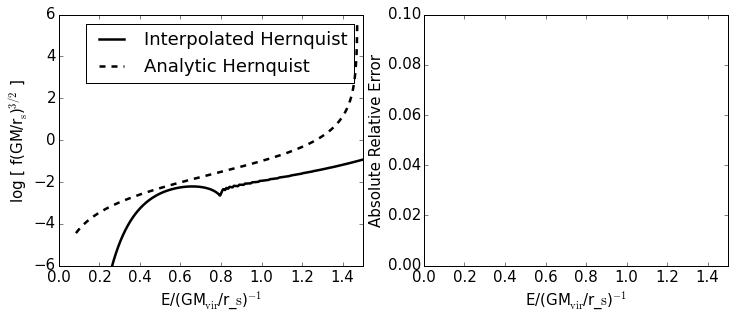

In [9]:
# now repeat the above, but with the spline interpolation at many E points:
E_array = np.linspace(np.min(NFW_DF.E), np.max(NFW_DF.E), 1000.0)

f_spline     = NFW_DF.interpolate_f(E_array, s = 0)
f_analytical = df.hernquist_df(E_array, NFW_DF.dprof.M_sys, NFW_DF.dprof.r_s)

####
E_const = ((cgs.G * NFW_DF.dprof.M_vir) / NFW_DF.dprof.r_s)**(-1.0)
f_const = (cgs.G  * NFW_DF.dprof.M_vir * NFW_DF.dprof.r_s)**(3.0/2.0)

error = (f_spline - f_analytical)/f_analytical

error = np.abs(error)

fsize = 15
#rc('text', usetex=True)
rc('font', size=fsize)#, ftype=42)
line_width = 2.5

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,4.5)
#ax1 = plt.subplot(211)

ax[0].plot(E_array*E_const, np.log10(f_spline * f_const), lw=line_width, label = "Interpolated Hernquist",color='black',ls='-')
ax[0].plot(E_array*E_const, np.log10(f_analytical * f_const), lw=line_width, label="Analytic Hernquist", color='black',ls='--')
ax[0].set_ylabel(r'log [ f(GM/r$_{\rm{s}}$)$^{3/2}$ ]')
ax[0].set_ylim(-6,6)
ax[0].legend(loc='best')
#ax2 = plt.subplot(221)

ax[1].plot(E_array * E_const, error, lw = line_width, color='black')
ax[1].set_ylabel(r'Absolute Relative Error')
for a in ax:
    a.set_xlim(0.0,1.5)
    a.set_xlabel(r'E/(GM$_{\rm{vir}}$/r_${\rm{s}}$)$^{-1}$')
ax[1].set_ylim(0.0,0.10)

fig.savefig('NFW_interpolated.png')
print np.max(error[:-1])

(0.0, 0.1)

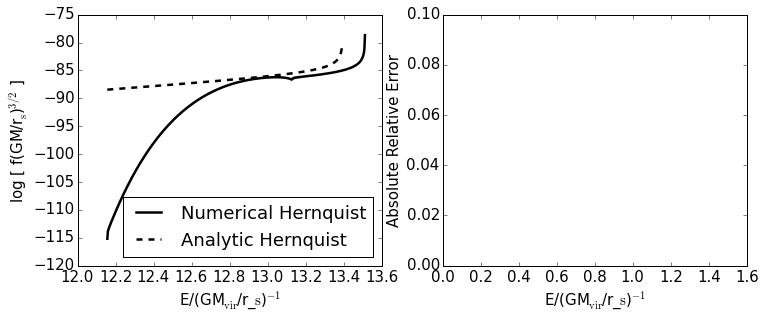

In [10]:
E_const = ((cgs.G * NFW_DF.dprof.M_vir) / NFW_DF.dprof.r_s)**(-1.0)
f_const = (cgs.G  * NFW_DF.dprof.M_vir * NFW_DF.dprof.r_s)**(3.0/2.0)
f_analytical = df.hernquist_df(NFW_DF.E, NFW_DF.dprof.M_sys, NFW_DF.dprof.r_s)
error = (NFW_DF.f - f_analytical)/f_analytical

error = np.abs(error)

fsize = 15
#rc('text', usetex=True)
rc('font', size=fsize)#, ftype=42)
line_width = 2.5

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,4.5)
#ax1 = plt.subplot(211)

ax[0].plot(np.log10(NFW_DF.E), np.log10(NFW_DF.f), lw=line_width, label = "Numerical Hernquist",color='black',ls='-')
ax[0].plot(np.log10(NFW_DF.E), np.log10(f_analytical), lw=line_width, label="Analytic Hernquist", color='black',ls='--')
ax[0].set_ylabel(r'log [ f(GM/r$_{\rm{s}}$)$^{3/2}$ ]')
ax[0].legend(loc='best')
#ax2 = plt.subplot(221)

ax[1].plot(NFW_DF.E * E_const, error, lw = line_width, color='black')
ax[1].set_ylabel(r'Absolute Relative Error')
for a in ax:
    a.set_xlabel(r'E/(GM$_{\rm{vir}}$/r_${\rm{s}}$)$^{-1}$')
ax[1].set_ylim(0.0,0.10)

#fig.savefig('Hernquest_DF.png')

[]

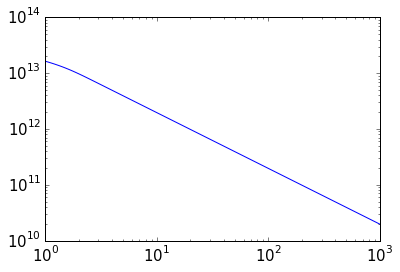

In [11]:
r = np.logspace(0.0,3.0,100.0)*cgs.kpc
rel_pot = NFW_DF.relative_potential(r)

plt.plot(r/cgs.kpc, rel_pot)
plt.loglog()

In [12]:
r = np.logspace(0.0,3.0,100.0)*cgs.kpc
density = NFW_DF.dprof.density(r)
plt.plot(r/cgs.kpc, density)
plt.loglog()

[]

/home/emerick/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


AttributeError: 'numpy.float64' object has no attribute '_mask'

In [ ]:
deriv =  NFW_DF._d2rho_dPsi2(r)
plt.plot(r/cgs.kpc,deriv)
plt.loglog()